In [1]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import os
import glob
import anndata as ad

In [2]:
nmix=8
num_markers = 20

In [3]:
spatialLIBD_dir = './data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.1
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.9.11
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.38.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
natsort             8.1.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.55.2
numexpr             2.8.3
numpy               1.22.4
packaging

### Load Single Cell Data

In [4]:
adata_sc_dlpfc = sc.read_h5ad('./data/sc_dlpfc/adata_sc_dlpfc.h5ad')
adata_sc_dlpfc.var_names_make_unique()
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


## Find Marker Genes

In [5]:
# #Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# # adata_sc_dlpfc_plot = sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])

In [6]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')

In [7]:
df_genelists = pd.read_pickle('data/sc_dlpfc/df_genelists.pkl')
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

# with open('data/res_genes_.json', 'w') as f:
#     json.dump(res_genes_, f)

### Select same gene features 

In [8]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), 
    label='sample_id', 
    keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)

normalizing counts per cell


/projects/wma/.conda2/envs/agreda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [9]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number', len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


## Format Data

## Generate Pseudospots

In [10]:
from sklearn.preprocessing import OneHotEncoder


def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

In [11]:
def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))

In [12]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())

In [13]:
# lab_sc_sub = df_sc.cell_subclass
# sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), set(lab_sc_sub)))
# sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
# lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
# lab_sc_num = np.asarray(lab_sc_num, dtype='int')

sc_mix_l = []
lab_mix_l = []
patient_l = []
for patient, df in df_sc.groupby(level='patient'):
    lab_sc_sub = df.index.get_level_values('cell_subclass')
    lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
    lab_sc_num = np.asarray(lab_sc_num, dtype='int')

    sc_mix, lab_mix = random_mix(
        df.to_numpy(), lab_sc_num, nmix=nmix, n_samples=len(df)
    )

    sc_mix_l.append(pd.DataFrame(np.log1p(sc_mix), columns=df.columns.to_numpy()))
    lab_mix_l.append(
        pd.DataFrame(
            lab_mix, columns=[sc_sub_dict[i] for i in np.unique(lab_sc_num)]
        )
    )
    patient_l.append(patient)

    # print(np.unique(lab_sc_num))

# sc_mix_s = log_minmaxscale(sc_mix)

# mat_sc_s = log_minmaxscale(mat_sc)


In [14]:
sc_mix_df = pd.concat(sc_mix_l, keys=patient_l, names=['subject'])
lab_mix_df = pd.concat(lab_mix_l, keys=patient_l, names=['subject']).fillna(0.)
lab_mix_df = lab_mix_df.reindex(columns=df_genelists.columns)

lab_mix_df['sample_id'] = lab_mix_df.index.get_level_values('subject')
sc_mix_df['sample_id'] = sc_mix_df.index.get_level_values('subject')
lab_mix_df = lab_mix_df.set_index('sample_id', append=True)
sc_mix_df = sc_mix_df.set_index('sample_id', append=True)
lab_mix_df = lab_mix_df.reorder_levels([0,2,1])
sc_mix_df = sc_mix_df.reorder_levels([0,2,1])

display(sc_mix_df)
display(lab_mix_df)

NR4A1    SLC6A1     RALYL    CHST11     CADPS  \
subject sample_id                                                          
2       2         0     0.000000  4.261947  6.644317  4.320549  5.575986   
                  1     0.000000  3.980171  7.525324  4.252063  5.550755   
                  2     0.000000  5.924202  6.205818  3.995326  4.278397   
                  3     0.000000  0.000000  6.921609  0.000000  5.467446   
                  4     0.000000  4.037597  7.550449  0.000000  5.684400   
...                          ...       ...       ...       ...       ...   
31      31        3283  0.000000  4.468482  6.483676  2.910491  6.382415   
                  3284  3.977679  3.448318  7.974993  0.000000  7.001760   
                  3285  0.000000  2.110371  6.762948  3.540390  6.076567   
                  3286  0.000000  0.000000  7.612805  6.413509  6.778067   
                  3287  0.000000  3.042479  7.888446  2.988463  7.016279   

                          SPOCK3       PKM   PRELID2     LRP1B     ALCAM  ...  \
subject sample_id                                                         ...   
2       2         0     6.040675  5.038130  3.180226  6.338298  0.000000  ...   
                  1     6.990634  4.569678  0.000000  7.062554  0.000000  ...   
                  2     5.670131  0.973028  2.932855  7.212901  5.916786  ...   
                  3     5.005500  6.104307  0.000000  6.953567  3.862123  ...   
                  4     4.851079  5.666082  0.000000  7.770959  4.121125  ...   
...                          ...       ...       ...       ...       ...  ...   
31      31        3283  7.042931  4.326857  2.910491  7.367384  4.644249  ...   
                  3284  5.628576  4.914910  3.078967  8.111060  4.469651  ...   
                  3285  6.757598  3.906146  0.000000  7.246098  4.496634  ...   
                  3286  5.373626  5.749409  0.000000  8.129324  5.855533  ...   
                  3287  4.686396  4.379872  4.902493  8.060661  3.429390  ...   

                        DLX6-AS1     YWHAG     NPAS3    KCTD16      NEFL  \
subject sample_id                                                          
2       2         0     0.000000  5.855064  6.571231  5.101256  0.000000   
                  1     0.000000  4.778549  4.318551  5.918956  0.000000   
                  2     0.000000  2.932855  7.499487  5.536706  4.604425   
                  3     0.000000  2.894044  6.971809  6.071994  0.000000   
                  4     0.000000  5.053672  7.446863  7.133036  4.037597   
...                          ...       ...       ...       ...       ...   
31      31        3283  4.803659  4.936785  7.125175  5.590279  4.255091   
                  3284  0.000000  5.409706  6.451548  6.712346  4.769405   
                  3285  3.906146  7.309589  7.711633  6.229954  3.906146   
                  3286  0.000000  6.169475  7.064431  6.666002  4.480641   
                  3287  4.002426  4.557111  5.779579  5.680069  4.589273   

                           BCAS1     KCNQ5   SLC35F3     MYO16       DST  
subject sample_id                                                         
2       2         0     0.000000  7.343704  5.486760  5.778976  6.246610  
                  1     3.587388  6.743920  5.321562  0.000000  5.661361  
                  2     3.599019  7.302536  3.643053  0.000000  7.161091  
                  3     0.000000  7.510806  6.444471  5.623951  6.464137  
                  4     0.000000  6.796658  4.041883  3.272442  5.360228  
...                          ...       ...       ...       ...       ...  
31      31        3283  1.915123  7.064825  4.853918  5.338403  5.796641  
                  3284  0.000000  7.687702  5.274051  3.442705  6.180614  
                  3285  0.000000  7.225044  3.321903  4.759330  6.952620  
                  3286  0.000000  7.066227  4.800695  5.776458  6.325290  
                  3287  6.410025  7.195518  5.797488  0.000000  5.256388  

[35212 rows x 362 c

Astros_1  Astros_2  Astros_3  Endo  Ex_1_L5_6  \
subject sample_id                                                       
2       2         0          0.0  0.000000  0.000000   0.0        0.0   
                  1          0.0  0.000000  0.000000   0.0        0.0   
                  2          0.0  0.224540  0.157588   0.0        0.0   
                  3          0.0  0.000000  0.000000   0.0        0.0   
                  4          0.0  0.130043  0.000000   0.0        0.0   
...                          ...       ...       ...   ...        ...   
31      31        3283       0.0  0.000000  0.000000   0.0        0.0   
                  3284       0.0  0.000000  0.000000   0.0        0.0   
                  3285       0.0  0.112475  0.000000   0.0        0.0   
                  3286       0.0  0.037498  0.000000   0.0        0.0   
                  3287       0.0  0.000000  0.013441   0.0        0.0   

                        Ex_2_L5  Ex_3_L4_5  Ex_4_L_6   Ex_5_L5  Ex_6_L4_6  \
subject sample_id                                                           
2       2         0         0.0   0.000000  0.000000  0.113268   0.000000   
                  1         0.0   0.000000  0.000000  0.000000   0.000000   
                  2         0.0   0.000000  0.000000  0.000000   0.000000   
                  3         0.0   0.000000  0.000000  0.202599   0.000000   
                  4         0.0   0.000000  0.000000  0.000000   0.000000   
...                         ...        ...       ...       ...        ...   
31      31        3283      0.0   0.000000  0.000000  0.000000   0.000000   
                  3284      0.0   0.000000  0.000000  0.007477   0.000000   
                  3285      0.0   0.000000  0.000000  0.000000   0.000000   
                  3286      0.0   0.199066  0.000000  0.073216   0.000000   
                  3287      0.0   0.000000  0.038811  0.040050   0.142095   

                        ...  Mix_1     Mix_2  Mix_3    Mix_4    Mix_5  OPCs_1  \
subject sample_id       ...                                                     
2       2         0     ...    0.0  0.088068    0.0  0.00000  0.00000   0.000   
                  1     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  2     ...    0.0  0.000000    0.0  0.14138  0.00000   0.000   
                  3     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  4     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
...                     ...    ...       ...    ...      ...      ...     ...   
31      31        3283  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3284  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3285  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3286  ...    0.0  0.000000    0.0  0.00000  0.04345   0.144   
                  3287  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   

                        OPCs_2  Oligos_1  Oligos_2  Oligos_3  
subject sample_id                                             
2       2         0        0.0       0.0       0.0  0.000000  
                  1        0.0       0.0       0.0  0.016445  
                  2        0.0       0.0       0.0  0.144754  
                  3        0.0       0.0       0.0  0.000000  
                  4        0.0       0.0       0.0  0.000000  
...                        ...       ...       ...       ...  
31      31        3283     0.0       0.0       0.0  0.324622  
                  3284     0.0       0.0       0.0  0.195517  
                  3285     0.0       0.0       0.0  0.139156  
                  3286     0.0       0.0       0.0  0.040179  
                  3287     0.0       0.0       0.0  0.309524  

[35212 rows x 33 columns]

In [15]:
mat_sp = adata_spatialLIBD.X.todense()

# mat_sp_s = log_minmaxscale(mat_sp)

mat_sp_s_df = pd.DataFrame(np.log1p(mat_sp))
mat_sp_s_df.index = pd.MultiIndex.from_arrays(
    [
        adata_spatialLIBD.obs.subject,
        adata_spatialLIBD.obs.sample_id,
        mat_sp_s_df.index
    ]
)
mat_sp_s_df.columns = adata_spatialLIBD.var_names
mat_sp_s_df

NR4A1    SLC6A1  RALYL    CHST11     CADPS  \
subject sample_id                                                        
Br5292  151509    0      0.000000  0.000000    0.0  0.000000  0.000000   
                  1      0.000000  0.000000    0.0  0.000000  5.929090   
                  2      6.040520  6.040520    0.0  0.000000  0.000000   
                  3      0.000000  6.181793    0.0  0.000000  0.000000   
                  4      0.000000  5.229878    0.0  0.000000  0.000000   
...                           ...       ...    ...       ...       ...   
Br5595  151669    47676  0.000000  5.296957    0.0  5.296957  5.987598   
                  47677  5.220865  0.000000    0.0  0.000000  5.220865   
                  47678  0.000000  6.118100    0.0  0.000000  5.427153   
                  47679  0.000000  5.681529    0.0  0.000000  0.000000   
                  47680  0.000000  6.132441    0.0  0.000000  0.000000   

                          SPOCK3       PKM  PRELID2     LRP1B   ALCAM  ...  \
subject sample_id                                                      ...   
Br5292  151509    0      0.00000  7.695668      0.0  0.000000  0.0000  ...   
                  1      0.00000  5.929090      0.0  0.000000  0.0000  ...   
                  2      0.00000  6.732476      0.0  0.000000  0.0000  ...   
                  3      5.49071  6.873906      0.0  0.000000  0.0000  ...   
                  4      0.00000  6.324914      0.0  0.000000  0.0000  ...   
...                          ...       ...      ...       ...     ...  ...   
Br5595  151669    47676  0.00000  6.902381      0.0  0.000000  0.0000  ...   
                  47677  0.00000  5.911307      0.0  5.220865  0.0000  ...   
                  47678  6.11810  6.810145      0.0  5.427153  6.1181  ...   
                  47679  0.00000  0.000000      0.0  0.000000  0.0000  ...   
                  47680  0.00000  6.824502      0.0  0.000000  0.0000  ...   

                         DLX6-AS1     YWHAG     NPAS3    KCTD16      NEFL  \
subject sample_id                                                           
Br5292  151509    0           0.0  7.695668  0.000000  6.310737  6.310737   
                  1           0.0  7.025928  0.000000  7.025928  0.000000   
                  2           0.0  6.732476  0.000000  0.000000  7.137544   
                  3           0.0  6.586569  0.000000  5.490710  6.181793   
                  4           0.0  7.422332  0.000000  5.229878  7.017166   
...                           ...       ...       ...       ...       ...   
Br5595  151669    47676       0.0  6.902381  5.296957  0.000000  6.392226   
                  47677       0.0  7.413276  0.000000  0.000000  6.825972   
                  47678       0.0  7.620462  0.000000  0.000000  5.427153   
                  47679       0.0  6.372971  0.000000  0.000000  7.065264   
                  47680       0.0  7.517105  0.000000  0.000000  6.132441   

                           BCAS1     KCNQ5  SLC35F3  MYO16       DST  
subject sample_id                                                     
Br5292  151509    0      0.00000  0.000000      0.0    0.0  0.000000  
                  1      0.00000  0.000000      0.0    0.0  0.000000  
                  2      6.04052  0.000000      0.0    0.0  0.000000  
                  3      0.00000  0.000000      0.0    0.0  0.000000  
                  4      0.00000  0.000000      0.0    0.0  0.000000  
...                          ...       ...      ...    ...       ...  
Br5595  151669    47676  0.00000  0.000000      0.0    0.0  0.000000  
                  47677  0.00000  5.220865      0.0    0.0  0.000000  
                  47678  0.00000  0.000000      0.0    0.0  5.427153  
                  47679  0.00000  0.000000      0.0    0.0  5.681529  
                  47680  0.00000  0.000000      0.0    0.0  0.000000  

[47681 rows x 362 columns]

In [16]:
# from sklearn.preprocessing import StandardScaler



# sc_mix_s_df = pd.DataFrame(sc_mix_s)
# sc_mix_s_df.index = pd.MultiIndex.from_arrays([[0 for _ in range(len(sc_mix_s_df))], sc_mix_s_df.index])
# sc_mix_s_df

# sc_mix_s_df = StandardScaler().fit_transform(sc_mix_s_df.loc[0])

In [17]:
import umap
from sklearn.decomposition import PCA


from sklearn.manifold import TSNE


def get_PCA_2D(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    return pca.transform(X)

def plot_scatter(X, labels, legend=None, title=""):
    markers=['o','o','o','^']
    n_clusters = labels.max() + 1
    
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
    
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        print(i, len(points))
        plt.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        plt.scatter(points[:, 0], points[:, 1], c='black', label='-1')
     
    plt.title(title)
    plt.legend()
    # plt.show()
    
def plot_scatter_subfig(X, labels, ax, legend=None, title=""):
    markers=['.','.','o','^']
    n_clusters = labels.max() + 1
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
        
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        ax.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    ax.legend(legend)
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        ax.scatter(points[:, 0], points[:, 1], c='black', label='-1')
        
    ax.set_title(title)

In [18]:
# for sample_id in all_z_df.loc[1].index.get_level_values(0).unique():
#     all_z_df.loc[(1, sample_id)] = StandardScaler().fit_transform(all_z_df.loc[(1, sample_id)])

In [19]:
all_df = pd.concat([sc_mix_df, mat_sp_s_df], keys = ['single-cell', 'spatial'], names=['domain'])

In [20]:
all_df

NR4A1    SLC6A1     RALYL    CHST11  \
domain      subject sample_id                                                 
single-cell 2       2         0      0.000000  4.261947  6.644317  4.320549   
                              1      0.000000  3.980171  7.525324  4.252063   
                              2      0.000000  5.924202  6.205818  3.995326   
                              3      0.000000  0.000000  6.921609  0.000000   
                              4      0.000000  4.037597  7.550449  0.000000   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  0.000000  5.296957  0.000000  5.296957   
                              47677  5.220865  0.000000  0.000000  0.000000   
                              47678  0.000000  6.118100  0.000000  0.000000   
                              47679  0.000000  5.681529  0.000000  0.000000   
                              47680  0.000000  6.132441  0.000000  0.000000   

                                        CADPS    SPOCK3       PKM   PRELID2  \
domain      subject sample_id                                                 
single-cell 2       2         0      5.575986  6.040675  5.038130  3.180226   
                              1      5.550755  6.990634  4.569678  0.000000   
                              2      4.278397  5.670131  0.973028  2.932855   
                              3      5.467446  5.005500  6.104307  0.000000   
                              4      5.684400  4.851079  5.666082  0.000000   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  5.987598  0.000000  6.902381  0.000000   
                              47677  5.220865  0.000000  5.911307  0.000000   
                              47678  5.427153  6.118100  6.810145  0.000000   
                              47679  0.000000  0.000000  0.000000  0.000000   
                              47680  0.000000  0.000000  6.824502  0.000000   

                                        LRP1B     ALCAM  ...  DLX6-AS1  \
domain      subject sample_id                            ...             
single-cell 2       2         0      6.338298  0.000000  ...       0.0   
                              1      7.062554  0.000000  ...       0.0   
                              2      7.212901  5.916786  ...       0.0   
                              3      6.953567  3.862123  ...       0.0   
                              4      7.770959  4.121125  ...       0.0   
...                                       ...       ...  ...       ...   
spatial     Br5595  151669    47676  0.000000  0.000000  ...       0.0   
                              47677  5.220865  0.000000  ...       0.0   
                              47678  5.427153  6.118100  ...       0.0   
                              47679  0.000000  0.000000  ...       0.0   
                              47680  0.000000  0.000000  ...       0.0   

                                        YWHAG     NPAS3    KCTD16      NEFL  \
domain      subject sample_id                                                 
single-cell 2       2         0      5.855064  6.571231  5.101256  0.000000   
                              1      4.778549  4.318551  5.918956  0.000000   
                              2      2.932855  7.499487  5.536706  4.604425   
                              3      2.894044  6.971809  6.071994  0.000000   
                              4      5.053672  7.446863  7.133036  4.037597   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  6.902381  5.296957  0.000000  6.392226   
                              47677  7.413276  0.000000  0.000000  6.825972   
                              47678  7.620462  0.000000  0.000000  5.427153   
                              47679  6.372971  0.000000  0.000000  7.065264   
                              47680  7.517105  0.000000  0.000000  6.1324

In [21]:
from sklearn.preprocessing import StandardScaler

for domain in all_df.index.get_level_values(0).unique():
    all_df.loc[(domain, slice(None), slice(None))] = StandardScaler().fit_transform(all_df.loc[(domain, slice(None), slice(None))])

In [22]:
all_df

NR4A1    SLC6A1     RALYL    CHST11  \
domain      subject sample_id                                                 
single-cell 2       2         0     -0.816105  0.301074 -0.331383  0.621305   
                              1     -0.816105  0.175385  0.717010  0.590602   
                              2     -0.816105  1.042534 -0.853194  0.475504   
                              3     -0.816105 -1.599998 -0.001407 -1.315647   
                              4     -0.816105  0.201000  0.746909 -1.315647   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676 -0.374402  1.002971 -0.428137  4.854665   
                              47677  2.427043 -0.810480 -0.428137 -0.193275   
                              47678 -0.374402  1.284094 -0.428137 -0.193275   
                              47679 -0.374402  1.134631 -0.428137 -0.193275   
                              47680 -0.374402  1.289004 -0.428137 -0.193275   

                                        CADPS    SPOCK3       PKM   PRELID2  \
domain      subject sample_id                                                 
single-cell 2       2         0     -0.804788  0.548884 -0.343183  0.327821   
                              1     -0.838211  1.107711 -0.714759 -1.137885   
                              2     -2.523720  0.330906 -3.567623  0.213812   
                              3     -0.948572 -0.060072  0.502509 -1.137885   
                              4     -0.661170 -0.150912  0.154908 -1.137885   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  1.601721 -0.478979  0.437811 -0.058959   
                              47677  1.312534 -0.478979  0.023980 -0.058959   
                              47678  1.390339  2.239594  0.399296 -0.058959   
                              47679 -0.656613 -0.478979 -2.444330 -0.058959   
                              47680 -0.656613 -0.478979  0.405291 -0.058959   

                                        LRP1B     ALCAM  ...  DLX6-AS1  \
domain      subject sample_id                            ...             
single-cell 2       2         0     -2.308243 -2.448376  ... -1.212124   
                              1     -0.955970 -2.448376  ... -1.212124   
                              2     -0.675255  0.803633  ... -1.212124   
                              3     -1.159463 -0.325660  ... -1.212124   
                              4      0.366706 -0.183306  ... -1.212124   
...                                       ...       ...  ...       ...   
spatial     Br5595  151669    47676 -0.239341 -0.471613  ... -0.220554   
                              47677  3.935361 -0.471613  ... -0.220554   
                              47678  4.100312  2.297336  ... -0.220554   
                              47679 -0.239341 -0.471613  ... -0.220554   
                              47680 -0.239341 -0.471613  ... -0.220554   

                                        YWHAG     NPAS3    KCTD16      NEFL  \
domain      subject sample_id                                                 
single-cell 2       2         0      0.112849  0.203843 -0.966823 -2.157147   
                              1     -0.787321 -2.072460 -0.061791 -2.157147   
                              2     -2.330670  1.141833 -0.484867  0.133655   
                              3     -2.363123  0.608621  0.107591 -2.157147   
                              4     -0.557266  1.088657  1.281954 -0.148354   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  0.470267  4.170899 -0.489091  0.382389   
                              47677  0.670257 -0.222586 -0.489091  0.538810   
                              47678  0.751361 -0.222586 -0.489091  0.034356   
                              47679  0.263029 -0.222586 -0.489091  0.625105   
                              47680  0.710901 -0.222586 -0.489091  0.2887

In [23]:
# data_pca = get_PCA_2D(all_df)
# data_umap = umap.UMAP().fit_transform(all_df)
# data_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=374).fit_transform(all_df)

data_pca_z = get_PCA_2D(all_df)
data_umap_z = umap.UMAP().fit_transform(all_df)
data_tsne_z = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=374).fit_transform(all_df)

/projects/wma/.conda2/envs/agreda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/projects/wma/.conda2/envs/agreda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [24]:
data_pca_z_df = pd.DataFrame(data_pca_z, index=all_df.index).reset_index()
data_umap_df = pd.DataFrame(data_umap_z, index=all_df.index).reset_index()
data_tsne_z_df = pd.DataFrame(data_tsne_z, index=all_df.index).reset_index()


data_pca_z_df['sample_id'] = data_pca_z_df['sample_id'].apply(str)
data_umap_df['sample_id'] = data_umap_df['sample_id'].apply(str)
data_tsne_z_df['sample_id'] = data_tsne_z_df['sample_id'].apply(str)

In [25]:
data_pca_z_df[data_pca_z_df['domain'] == domain]

,domain,subject,sample_id,level_3,0,1
35212,spatial,Br5292,151509,0,2.834078,-2.481054
35213,spatial,Br5292,151509,1,-0.610398,0.990934
35214,spatial,Br5292,151509,2,0.151907,0.682347
35215,spatial,Br5292,151509,3,-3.595914,1.415897
35216,spatial,Br5292,151509,4,-3.362015,2.395447
...,...,...,...,...,...,...
82888,spatial,Br5595,151669,47676,-1.170850,2.368260
82889,spatial,Br5595,151669,47677,-2.851587,2.203064
82890,spatial,Br5595,151669,47678,-2.896022,0.855814
82891,spatial,Br5595,151669,47679,-0.958369,0.900501


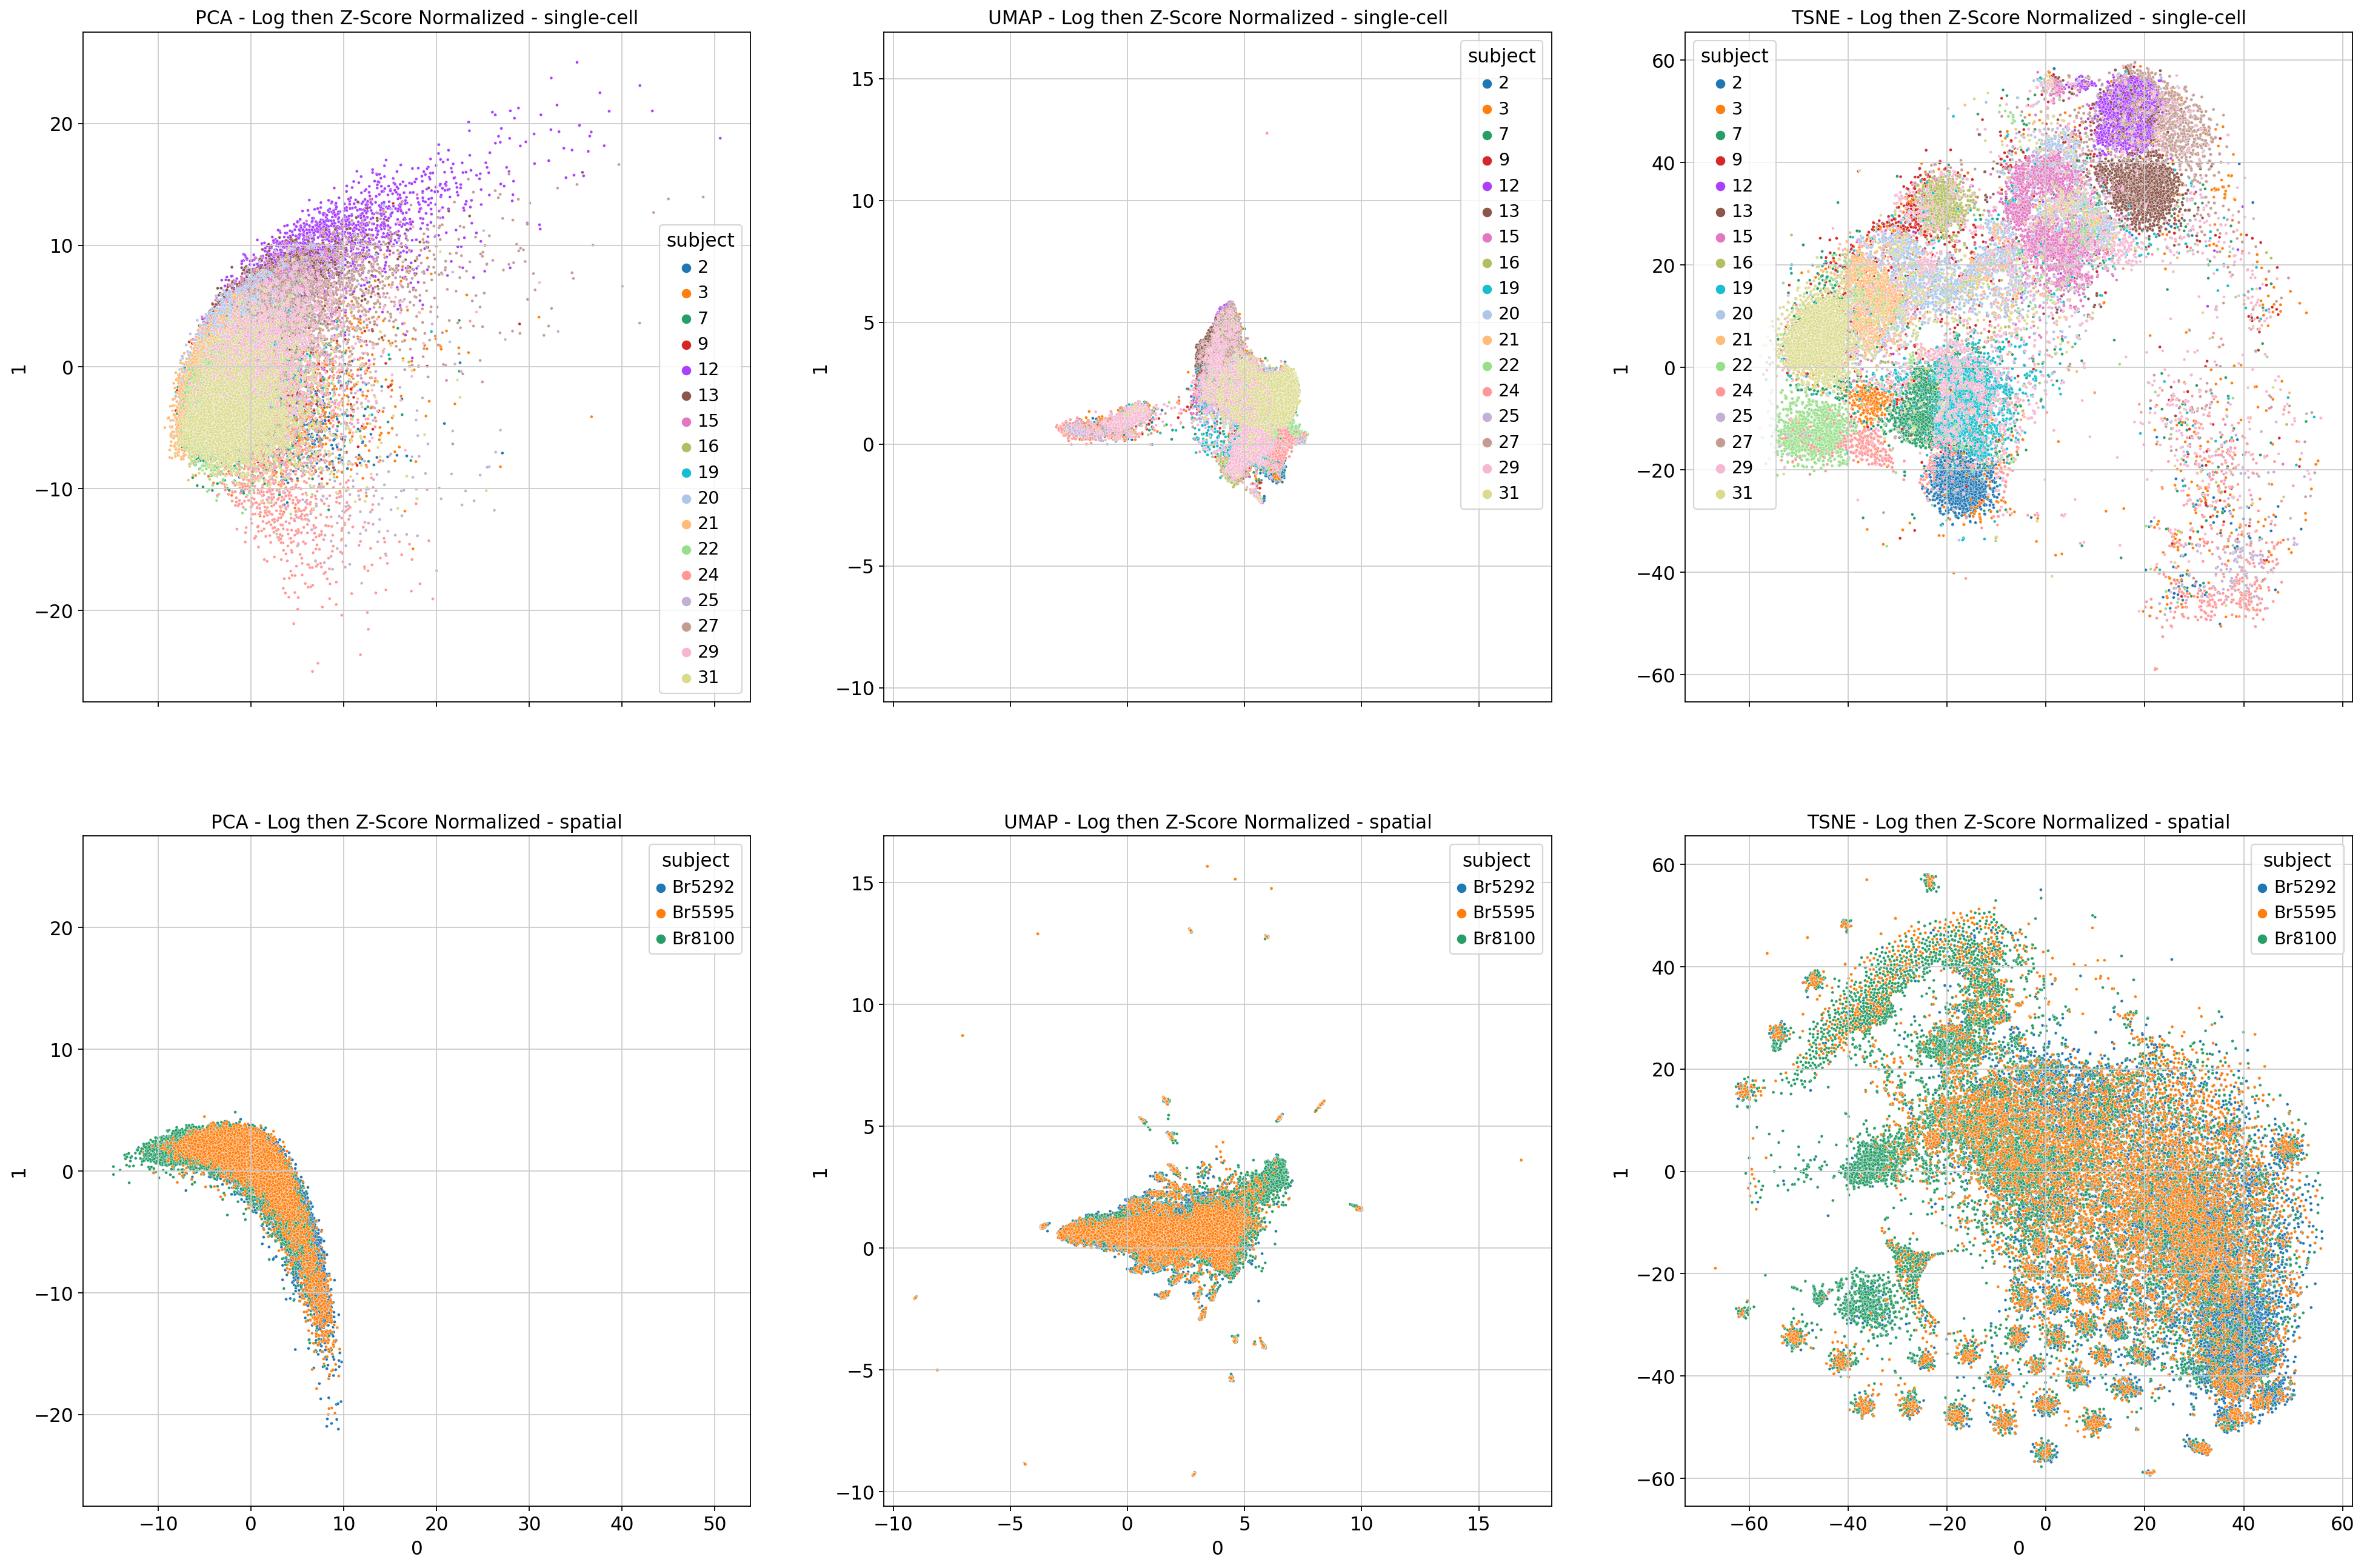

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(30, 20), sharex='col', sharey='col')
# plot_scatter_subfig(data_pca, all_df.index.get_level_values(0).to_numpy(), axs[0][0], title=f'PCA - Min-Max Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_umap, all_df.index.get_level_values(0).to_numpy(), axs[0][1], title=f'UMAP - Min-Max Normalized', legend=['sc', 'st'])

# plot_scatter_subfig(data_pca_z, all_df.index.get_level_values(0).to_numpy(), axs[0], title=f'PCA - Log then Z-Score Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_umap_z, all_df.index.get_level_values(0).to_numpy(), axs[1], title=f'UMAP - Log then Z-Score Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_tsne_z, all_df.index.get_level_values(0).to_numpy(), axs[2], title=f'TSNE - Log then Z-Score Normalized', legend=['sc', 'st'])

# markers = {'single-cell': '_', 'spatial': '|'}
for i, domain in enumerate(data_pca_z_df['domain'].unique()):
    sns.scatterplot(
        data=data_pca_z_df[data_pca_z_df['domain'] == domain],
        x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        s=5,
        # markers=markers,
        ax=axs[i][0],
    )
    sns.scatterplot(
        data=data_umap_df[data_umap_df['domain'] == domain],
            x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        # markers=markers,
        s=5,
        ax=axs[i][1]
    )
    sns.scatterplot(
        data=data_tsne_z_df[data_tsne_z_df['domain'] == domain],
            x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        # markers=markers,
        s=5,
        ax=axs[i][2]
    )

    axs[i][0].set_title(f'PCA - Log then Z-Score Normalized - {domain}')
    axs[i][1].set_title(f'UMAP - Log then Z-Score Normalized - {domain}')
    axs[i][2].set_title(f'TSNE - Log then Z-Score Normalized - {domain}')

# fig.suptitle(f'Single Cell (DLPFC Nagy et al. controls, pseudo-spots of n=8) vs Spatial Transcriptomic (spatialLIBD DLPFC sample {all_z_df.loc[1].index.get_level_values(0)[0]})')

plt.show(block=False)

In [27]:
Z = sch.linkage(all_df, method='ward', metric = 'euclidean')

/tmp/ipykernel_1528474/1644917950.py:76: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',


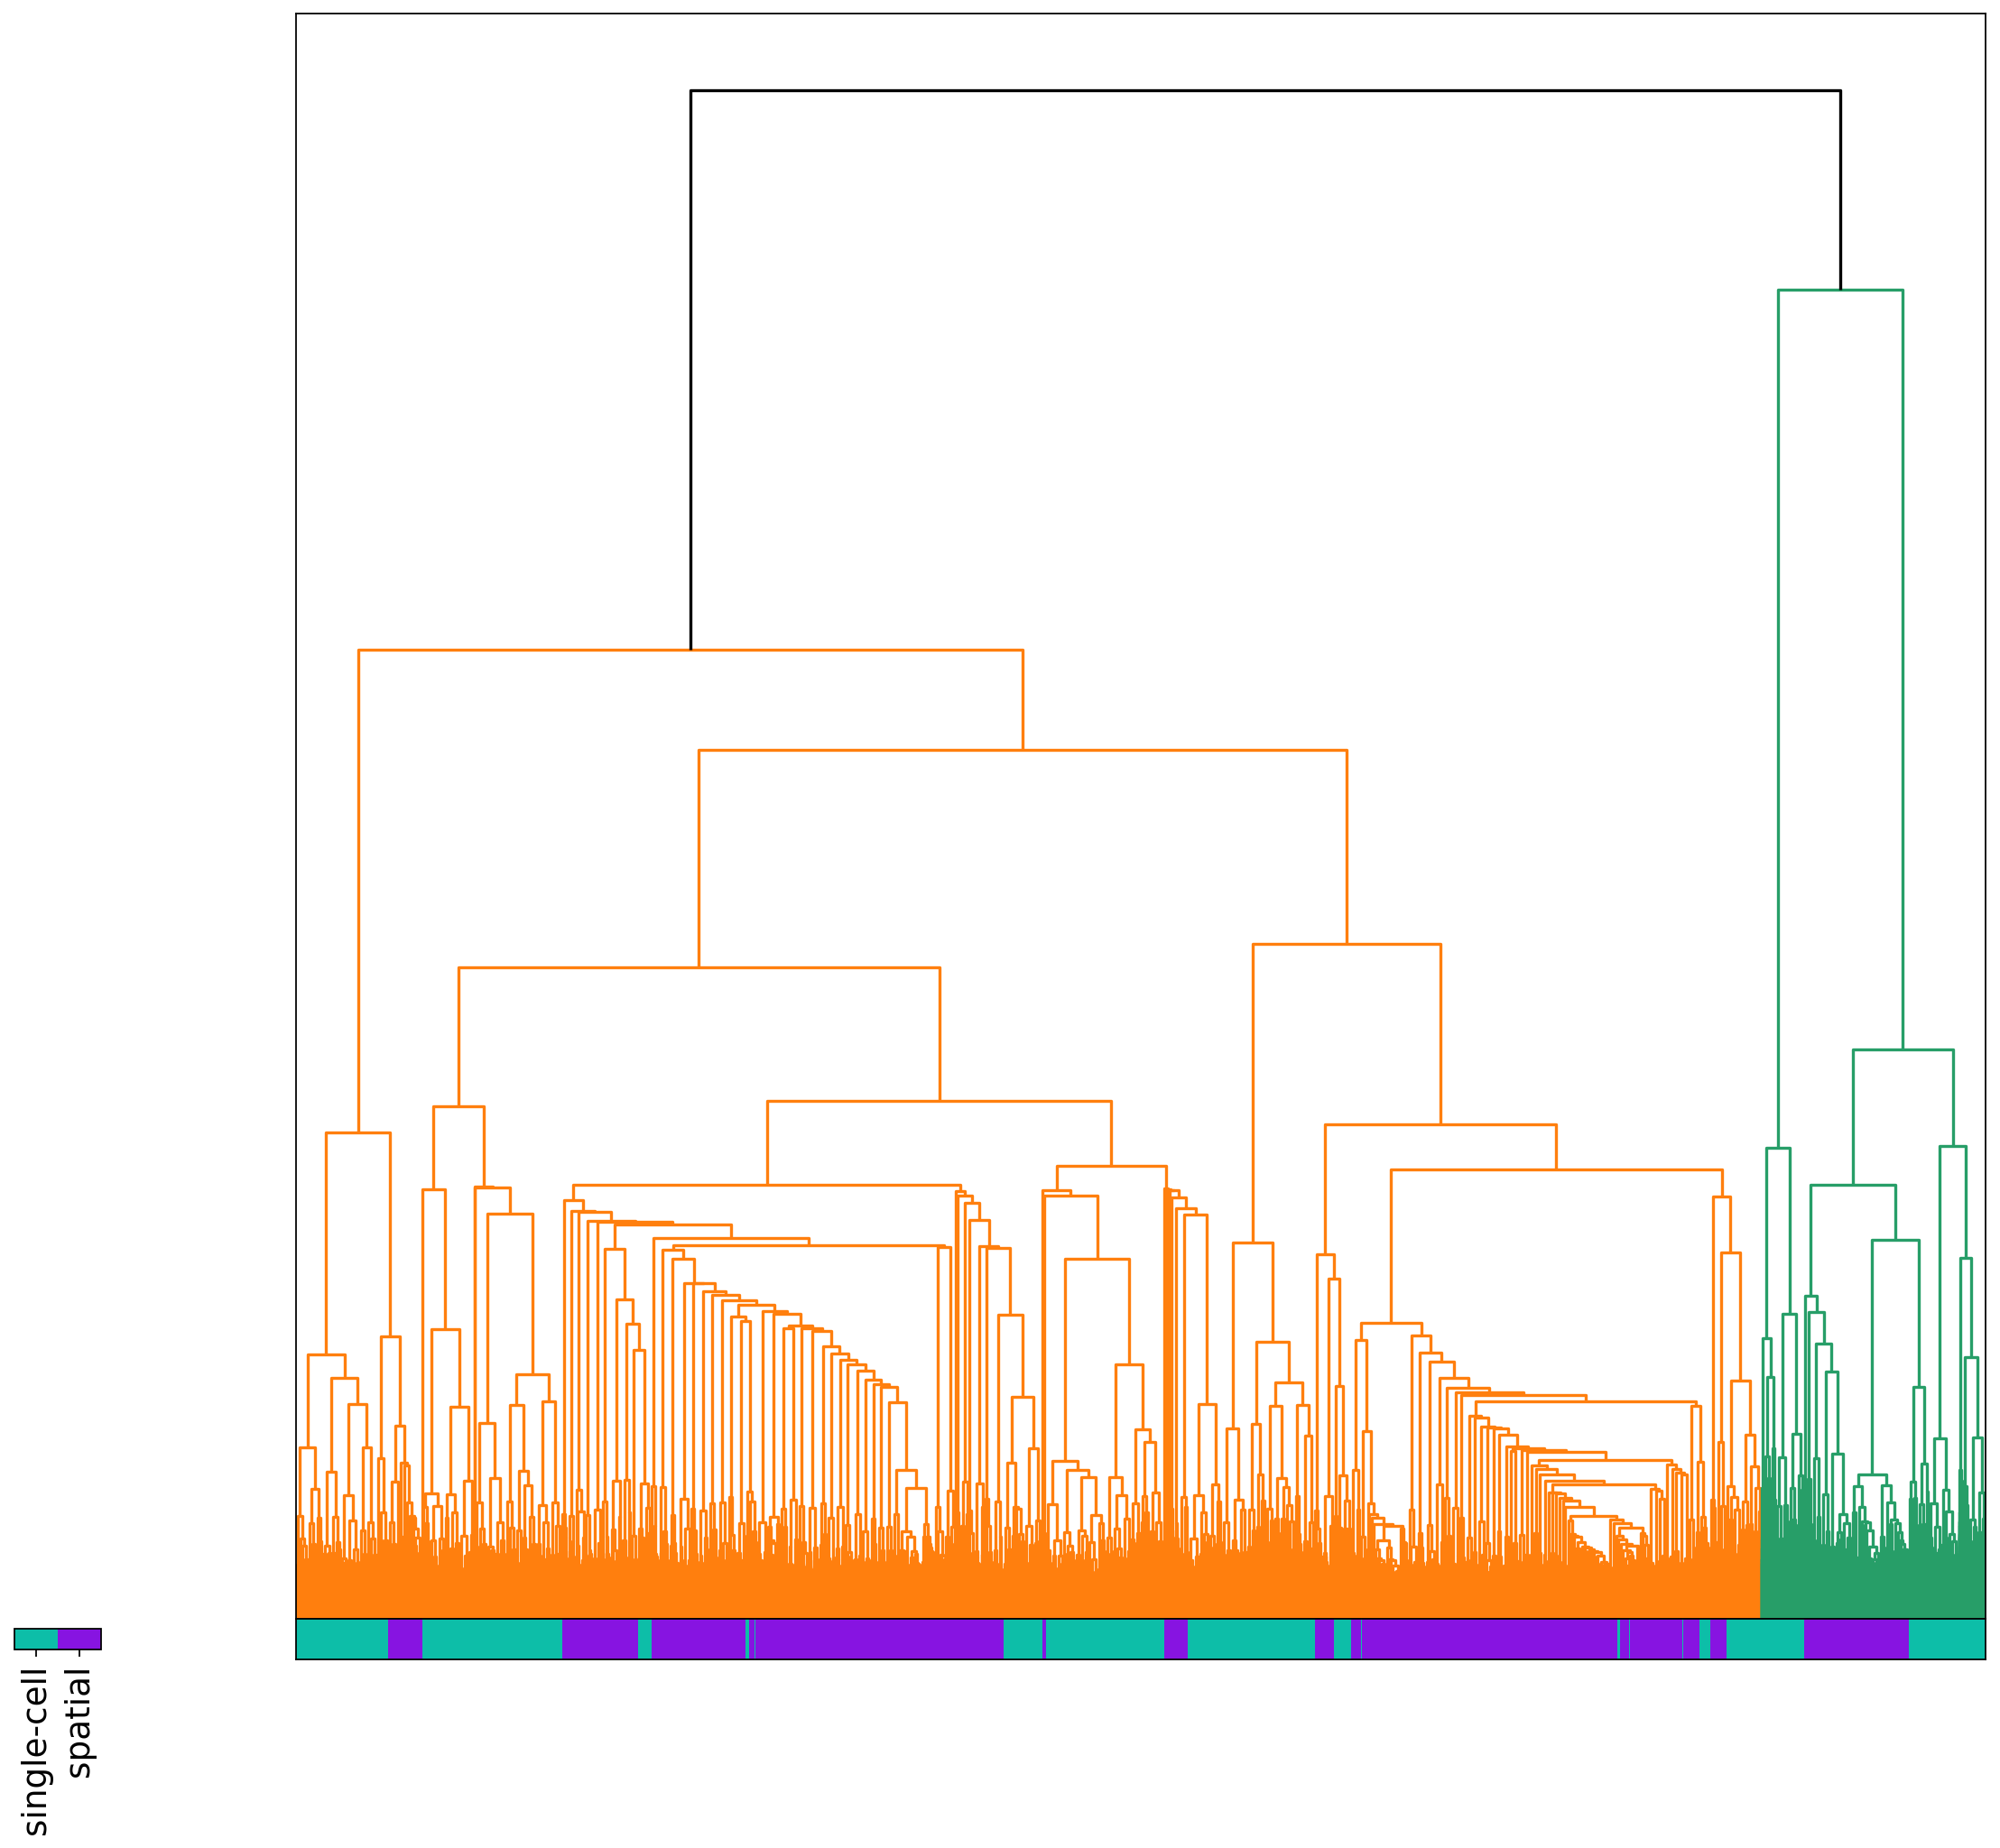

In [28]:
# # import matplotlib.cm
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)),
        N=n
    )
    return new_cmap

from matplotlib.colors import rgb2hex
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,
                       1,
                       height_ratios=[39, 1],
                       hspace=0.00)

ax2 = fig.add_subplot(gs[0])#add_axes([0,0.75,1,0.45])




clust_labels = all_df.index.get_level_values('domain').to_numpy()
le = preprocessing.LabelEncoder()
clust_labels = le.fit_transform(all_df.index.get_level_values('domain').to_numpy())

Z2 = sch.dendrogram(Z, color_threshold = Z[len(Z) - 2+1,2],  above_threshold_color='k')

ax2.set_xticks([])
ax2.set_yticks([])

# label clusters
clust_labels_dendo = clust_labels[Z2['leaves']]

idx2 = Z2['leaves']





axb = fig.add_subplot(gs[1])


cat_vals = clust_labels[idx2]

n=(~np.isnan(np.unique(cat_vals))).sum()

cmap = plt.cm.get_cmap('bwr', n)
cmap = mcolors.ListedColormap(['#0dbea8', '#8714e1'])

cmap.set_bad('white',1.)

neg = axb.matshow(np.atleast_2d(cat_vals),
                       aspect='auto',
                       origin='lower',
                            cmap=cmap)

pos1 = axb.get_position() # get the original position 
cbaxes = fig.add_axes([0.05, pos1.y0 + pos1.height / 4.0,  0.08*(~np.isnan(np.unique(cat_vals))).sum()/4, pos1.height / 2.0])
ticks = np.unique(cat_vals[~np.isnan(cat_vals)])
cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',
                    ticks=[tick-(tick-ticks.mean())/len(ticks) for tick in ticks])
#                             ticks=ticks
#         tick_locs = (np.arange(n) + 0.5)*(n-1)/n
#         cbar.ax.set_ticks(tick_locs)

cbar.ax.set_xticklabels(le.classes_,rotation=90,fontsize='large')


axb.set_yticks([])
axb.set_xticks([])
    # axb.text(-0.01,
    #      0.5,
    #      cat_bar_var,
    #      horizontalalignment='right',
    #      verticalalignment='center',
    #      transform=bar_axs_cat[i].transAxes,
    #                     fontsize='large'
    #     )
#     bar_axs_cat[i].legend(np.unique(labels[cat_bar_var][[(legend[cat_bar_var][label_name] != 'Indeterminate') for label_name in labels[cat_bar_var]]]).tolist(),
#                           [x for x in legend[cat_bar_var] if x != 'Indeterminate'])
    


#     for vert_po in vert_pos:
#         bar_axs_cat[i].axvline(vert_po, color='k', alpha=1)

# pos_hm = axmatrix.get_position()
# cbaxes = fig.add_axes([0.05, pos_hm.y0+ pos1.height*2, 0.13, pos1.height])  #[left, bottom, width, height]
# cbar = plt.colorbar(im,
#                     cax=cbaxes,
#                     orientation='horizontal',
#                     ticks=[1/(1+np.exp(steeepness*2)),
#                            1/(1+np.exp(steeepness*1)),
#                            1/(1+np.exp(steeepness*0)),
#                            1/(1+np.exp(-steeepness*1)),
#                            1/(1+np.exp(-steeepness*2))])
# cbar.ax.set_xticklabels(['-2', '-1', '0', '1', '2'], fontsize='xx-large')  # vertically oriented colorbar
# cbar.ax.xaxis.tick_left()

# fig.suptitle("\n".join(wrap(f'Dendogram and Heatmap - {params_clust["num_clusters"]} Clusters - subset={subset_str}', 100)),y=0.9)

# plt.savefig(os.path.join(results_dir_out, f'Dendo_heat-{params_clust["num_clusters"]}_clusters.png'), dpi=300)
plt.show(block=False)


In [29]:
agglo_clust = sch.cut_tree(Z, n_clusters=2).T[0]

In [30]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

clf =  RandomForestClassifier(random_state=23, n_jobs=-1)
# clf = SVC(gamma=2, C=1)
# clf = LogisticRegression()



X_train, X_test, y_train, y_test = train_test_split(
    all_df, clust_labels, test_size=0.2, random_state=256
)

clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(1.0, 1.0)

In [31]:
y_test.mean(), y_train.mean()

(0.5744013511068219, 0.5754139397412311)

In [32]:
clf = SVC(random_state=20)
# clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

In [ ]:
# clf = SVC(gamma=2, C=1)
clf = LogisticRegression(random_state=27)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.5744616683756559, 0.5753837801972435)